In [92]:
from torch_lib.Dataset import *
from library.Math import *
from library.Plotting import *
from torch_lib import Model, ClassAverages
from yolo.yolo import cv_Yolo

In [93]:
import os
import time
import numpy as np
import cv2

In [94]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision.models import vgg

In [95]:
import matplotlib.pyplot as plt

In [96]:
video = False
imageFolder = '/media/hpahadia_3/DATAPART1/2D3DBB/eval/image_2/'
videoFolder = '/home/hpahadia_3/Documents/3ddeepbox/code/3D-BoundingBox/Kitti/video/'
image_ext = '.png'
# Make sure calibration files have same name as image files
calFolder = '/media/hpahadia_3/DATAPART1/2D3DBB/eval/calib/'

calib_file = calFolder+'calib_cam_to_cam.txt'

In [97]:
bins = 2

In [98]:
all_models = []
weight_dir = os.path.abspath(os.getcwd()) + '/weights/'
for a in sorted(os.listdir(weight_dir)):
    if a.endswith('.pkl'):
        all_models.append(a)
all_models

['epoch_10.pkl', 'epoch_20.pkl']

# Initialize model

In [99]:
if len(all_models) == 0:
    print('No models found, please train!')
else:
    print('Initializing previous model',all_models[-1])
    myvgg = vgg.vgg19_bn(pretrained=True)
    model = Model.Model(features=myvgg.features, bins=bins).cuda()
    checkpoint = torch.load(weight_dir+all_models[-1])
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

Initializing previous model epoch_20.pkl


In [100]:
# load yolo
yolo_path = os.path.abspath(os.getcwd()) + '/weights/'
yolo = cv_Yolo(yolo_path)

In [101]:
averages = ClassAverages.ClassAverages()
angle_bins =  generate_bins(bins=2)

angle_bins

array([1.57079633, 4.71238898])

In [102]:
if video:
    image_dir = videoFolder
else:
    image_dir = imageFolder

In [103]:
idx = []
try:
    for a in sorted(os.listdir(image_dir)):
        idx.append(a.split('.')[0])
except:
    print('No images for eval!')

In [104]:
def plot_regressed_3d_bbox(img, cam_to_img, box_2d, dimensions, alpha, theta_ray, img_2d=None):

    location, X = calc_location(dimensions, cam_to_img, box_2d, alpha, theta_ray)

    orient = alpha + theta_ray

    if img_2d is not None:
        plot_2d_box(img_2d, box_2d)

    plot_3d_box(img, cam_to_img, orient, dimensions, location) # 3d boxes

    return location

(370, 1224, 3)
(375, 1242, 3)
continue 1 train
(375, 1242, 3)
(375, 1242, 3)
<class 'torch_lib.Dataset.DetectedObject'> continue 2
(375, 1242, 3)
(375, 1242, 3)
(374, 1238, 3)
(375, 1242, 3)
(375, 1242, 3)
(375, 1242, 3)
(375, 1242, 3)


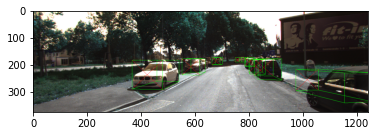

In [107]:
for i,imgid in enumerate(idx):
    stime = time.time()
    img_file = image_dir+imgid+image_ext
    
    image = cv2.imread(img_file)
    img = np.copy(image)
    yoloimg = np.copy(image)
#     print(img_file)
    
    # run yolo first
    detections = yolo.detect(yoloimg)
#     print(len(detections))
    
    for detection in detections:
        if not averages.recognized_class(detection.detected_class):
            print('continue 1', detection.detected_class)
            
            continue
            
        try:
            detectedobject = DetectedObject(img, detection.detected_class, detection.box_2d, calib_file)
        except:
            print(type(detectedobject),'continue 2')
            continue
        theta_ray = detectedobject.theta_ray
        input_img = detectedobject.img
        proj_matrix = detectedobject.proj_matrix
        box_2d = detection.box_2d
        detected_class = detection.detected_class
        
        input_tensor = torch.zeros([1, 3, 224, 224]).cuda()
        input_tensor[0,:,:,:] = input_img
        
        [orient, conf, dim] = model(input_tensor)
        orient = orient.cpu().data.numpy()[0, :, :]
        conf = conf.cpu().data.numpy()[0, :]
        dim = dim.cpu().data.numpy()[0, :]
        dim += averages.get_item(detected_class)
        

        argmax = np.argmax(conf)
        orient = orient[argmax, :]
        cos = orient[0]
        sin = orient[1]
        alpha = np.arctan2(sin, cos)
        alpha += angle_bins[argmax]
        alpha -= np.pi
        
#         print(proj_matrix, box_2d, dim, alpha, theta_ray)
        
        location = plot_regressed_3d_bbox(img, proj_matrix, box_2d, dim, alpha, theta_ray, image)
        plt.imshow(img)
        
    if i == 10:
        break

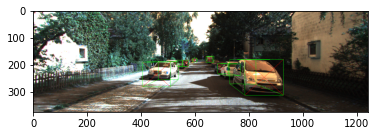

In [91]:
plt.imshow(img)